# Discretized VFI: Income Fluctuation

Consider the most basic income fluctuation problem

\begin{align*}
  V(a_t, s_t) &= u(c_t) + \beta E \left[ V(a_{t+1}, s_{t+1}) \right] \\
  &\text{Subject to } \\
  &c_t + a_{t+1} = (1 + r) a_t + y(s_t)
\end{align*}

Let utility be given by CRRA preferences: $u(c_t) = (c_t^{1 - \gamma} - 1) / (1 - \gamma)$

Let the stochastic process be a discrete Markov process with transition matrix, $P$

$$P = \begin{bmatrix} 0.95 & 0.05 & 0.0 \\ 0.10 & 0.70 & 0.20 \\ 0.0 & 0.25 & 0.75 \end{bmatrix}$$

Let the endowments be given by $y(s_t) = \{0.25, 0.75, 1.0\}$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import quantecon as qe

from numba import jit

%matplotlib inline

## Helper functions

In [2]:
@jit(nopython=True)
def u(gamma, c):
    if c<1e-10:
        return -1e10
    else:
        return (c**(1-gamma) - 1.0) / (1-gamma)

@jit(nopython=True)
def fill_flow_u(gamma, r, agrid, ygrid):
    # Get sizes
    na = agrid.size
    ny = ygrid.size

    # Allocate array (a_t, y_t, a_{t+1})
    out = np.empty((na, ny, na))

    for i_at in range(na):
        _at = agrid[i_at]
        for i_yt in range(ny):
            _yt = ygrid[i_yt]
            for i_atp1 in range(na):
                _atp1 = agrid[i_atp1]
                _c = (1 + r)*_at + _yt - _atp1
                out[i_at, i_yt, i_atp1] = u(gamma, _c)

    return out

## Algorithm

In [3]:
class IFP(object):
    """
    This class is used to solve the income fluctuation problem
    """
    def __init__(self, beta=0.95, gamma=2.0, r=0.025,
                 na=250, a_lb=-4.75, a_ub=7.5,
                 P=np.array([[0.95, 0.05, 0.0], [0.10, 0.70, 0.20], [0.0, 0.25, 0.75]]),
                 ygrid=np.array([0.25, 0.75, 1.0])):
        # Save fundamentals of model
        self.beta, self.gamma, self.r = beta, gamma, r
        self.P, self.ygrid = P, ygrid

        # Save grids and relevant info about grids
        self.na, self.ny = na, ygrid.size
        self.agrid = np.linspace(a_lb, a_ub, na)

        # Evaluate utility function along entire grid
        self.U = fill_flow_u(self.gamma, self.r, self.agrid, self.ygrid)

        # Initial guess at value function
        self.V0 = np.zeros((self.na, self.ny))

    def solve_loops(self, tol=1e-8, maxit=100):
        # Unpack parameters and relevant info
        beta, gamma, r = self.beta, self.gamma, self.r
        P, ygrid, agrid = self.P, self.ygrid, self.agrid
        U = self.U
        na, ny = self.na, self.ny

        # Initialize counters
        dist, it = 10.0, 0

        # Create value functions to update
        V_old = np.copy(self.V0)
        V = np.empty((na, ny))
        A = np.empty((na, ny), dtype=np.int)

        while (dist > tol) and (it < maxit):
            for (i_a, a) in enumerate(agrid):
                for (i_y, y) in enumerate(ygrid):
                    astar = -1
                    Vstar = -1e10
                    for (i_ap, ap) in enumerate(agrid):
                        # Compute value of current policy
                        EV = np.dot(P[i_y, :], V_old[i_ap, :])
                        curr_val = U[i_a, i_y, i_ap] + beta*EV

                        # Check whether better than previous one
                        if curr_val > Vstar:
                            astar = i_ap
                            Vstar = curr_val

                    # Update values
                    V[i_a, i_y] = Vstar
                    A[i_a, i_y] = astar

            # Update iterators
            dist = np.max(np.abs(V - V_old))
            it += 1
            np.copyto(V_old, V)

            if it%25 == 0:
                print("Iteration: {}\t\tDistance: {}".format(it, dist))
            
        return A, V

    def solve_vec(self, tol=1e-8, maxit=100):
        # Unpack parameters and relevant info
        beta, gamma, r = self.beta, self.gamma, self.r
        P, ygrid, agrid = self.P, self.ygrid, self.agrid
        U = self.U
        na, ny = self.na, self.ny

        # Initialize counters
        dist, it = 10.0, 0

        # Create value functions to update
        V_old = np.copy(self.V0)
        V = np.empty((na, ny))
        A = np.empty((na, ny), dtype=np.int)

        while (dist > tol) and (it < maxit):
            # Compute expected value of each point on grid
            EV = P @ V_old.T  # E[V(a_{t+1}, y_{t+1}) | y_t] => (ny x na)

            # Make things (1, 1, na)
            big_V = U + beta*EV[None, :, :]

            # Find policy and update V
            A = np.argmax(big_V, axis=2)
            np.copyto(V, np.max(big_V, axis=2))

            # Update iterators
            dist = np.max(np.abs(V - V_old))
            it += 1
            np.copyto(V_old, V)

            if it%25 == 0:
                print("Iteration: {}\t\tDistance: {}".format(it, dist))
            
        return A, V

In [4]:
ifp = IFP()

In [5]:
%time A, V_loop = ifp.solve_loops()

Iteration: 25		Distance: 0.9734247596242511
Iteration: 50		Distance: 0.21026920040468156
Iteration: 75		Distance: 0.053254982228295944
Iteration: 100		Distance: 0.014234935671041171
CPU times: user 29.2 s, sys: 520 ms, total: 29.7 s
Wall time: 29.2 s


In [6]:
%time A, V_vec = ifp.solve_vec();

Iteration: 25		Distance: 0.9734247596242511
Iteration: 50		Distance: 0.21026920040468156
Iteration: 75		Distance: 0.053254982228295944
Iteration: 100		Distance: 0.014234935671041171
CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 53.3 ms


In [7]:
%time A, V = ifp.solve_vec(tol=1e-8, maxit=5000);

Iteration: 25		Distance: 0.9734247596242511
Iteration: 50		Distance: 0.21026920040468156
Iteration: 75		Distance: 0.053254982228295944
Iteration: 100		Distance: 0.014234935671041171
Iteration: 125		Distance: 0.0038849463520733707
Iteration: 150		Distance: 0.001069765446487736
Iteration: 175		Distance: 0.0002957684991287124
Iteration: 200		Distance: 8.192408658658223e-05
Iteration: 225		Distance: 2.2710365655598252e-05
Iteration: 250		Distance: 6.297847150449343e-06
Iteration: 275		Distance: 1.7467410060589827e-06
Iteration: 300		Distance: 4.845013847898372e-07
Iteration: 325		Distance: 1.3439245094559737e-07
Iteration: 350		Distance: 3.727868147507252e-08
Iteration: 375		Distance: 1.0340713174628036e-08
CPU times: user 184 ms, sys: 4 ms, total: 188 ms
Wall time: 187 ms


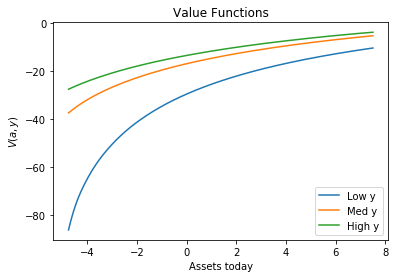

In [8]:
fig, ax = plt.subplots()

ax.plot(ifp.agrid, V)

ax.set_title("Value Functions")
ax.set_xlabel("Assets today")
ax.set_ylabel(r"$V(a, y)$")
ax.legend(labels=["Low y", "Med y", "High y"])

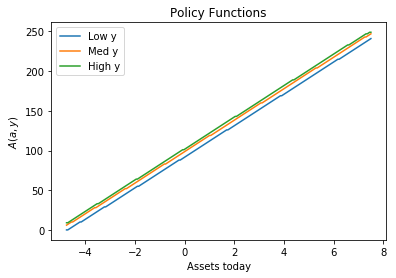

In [9]:
fig, ax = plt.subplots()

ax.plot(ifp.agrid, A)

ax.set_title("Policy Functions")
ax.set_xlabel("Assets today")
ax.set_ylabel(r"$A(a, y)$")
ax.legend(labels=["Low y", "Med y", "High y"])